In [29]:
%matplotlib inline
import csv
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
import numpy as np
import ast
import pandas as pd
import io
from random import random, randint

# Account clock experiments

- Each account has two sets: Spend Set and Claim Set: 
    + Sets are essentially an array, where each index corresonds to the transaction partner (input or output)
    + Each set value is an aggregate of total balance: total up/ total down
    + Claim set with index zero is minting claim and such claim must be provided with a proof of minting
- Each transaction has link to the two set aggregate. 



### Create an interaction network

25886
64299


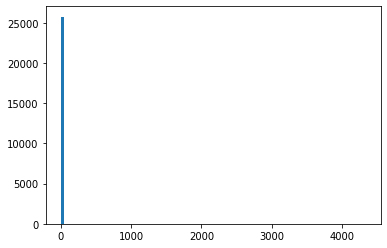

In [90]:
from math import log

# Auxilary functions
def construct_graph(filename):
    G = nx.Graph()
    with open(filename, "r") as csvfile:
        first = True
        for k in csvfile:
            if first:
                first = False
                continue
            a, b = k.split(",")
            G.add_edge(int(a), int(b))
    return G

    
def query_neighbors(G, p1, pn):
    '''
    p1 queries pn about neighbors of the graph G
    '''
    # Honest answer
    return G[pn]


# initialize peers/ Create and Overlay network  
N = 500
#G = construct_graph("GraphDynamics/peer_connections.log.txt")
M = N**(1/3) * N
p = (log(N) - log(log(N))+1)/(1-log(log(N))/3)
p = p / N
#G = nx.gnp_random_graph(N, p)
#G = nx.gnm_random_graph(N, p*N*N)

G = nx.read_gml("Datasets/ripple-graph.gml")
#G = G.to_undirected()10012
#G = construct_graph("/home/bulat/project/DetectionExperiments/noodles/Datasets/test_peers_q.log")
# Discovery community after 210 seconds 
print(G.number_of_nodes())
print(G.number_of_edges())
x = sorted([d for n, d in G.degree()], reverse=True)

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 100, density=False)
fig.canvas.draw()
plt.show()




## Experiments with clocks

25886
64299


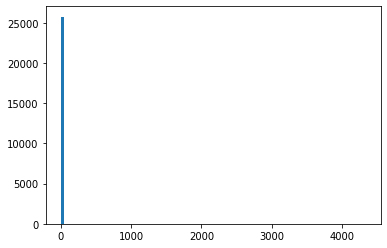

In [298]:

class State:
    def __init__(self, my_id, neigh_set):
        self.claim_set = {k:0 for k in neigh_set}
        self.spend_set = {k:0 for k in neigh_set}
        self.claim_set[my_id] = 0
    
    def compress(self):
        return (self.claim_set, self.spend_set)

class Peer:
    ''' 
    Partner must have enough balance. For this we need to calculate spends and claims:
      1. All spends must be fullfilled. Nothing should be missed
        - Peer can synchronize with other parties to ensure that. 
        - Depending on the double spending policy, peer must decide what to do if double spending happends.
          Potentially, all spends, including double spends might be accounted. 
          Otherwise peer when detecting can exlude other peer.  
      2. Claims must be valid. A valid claim must fullfill following conditions: 
        - Claim must initally come from a trusted/verified source, either trusted minter, miner, transaction fee, etc.
        - If claim does not come from the peer itself(minting, mining), the previous owner balance must be accountable.
        - If the transaction links to the peer itself, the transaction is valid. 
        - Otherwise the claim has a vector clock of last timestamp. 
          Such timestamp can be used as the verification pointer for the third party. 
          For example, A has a balance estimation for the peer B at timestamp (0, 2, 1, 10). 
          Then if C comes to A with a spend from B that is older than the timestamp, claim of C that is linked to this timestamp is valid. 
        - Peer cannot verify everything directly. A confirmation from at least K near witness would convince peer A.   
    '''
    def __init__(self, my_id, neigh_set, chain_budget=100, peer_budget=10, wit_count=3, weight_set=None):
        self.my_id = my_id
        self.neigh_set = neigh_set
        self.weight_set = weight_set
        self.chain = []
        self.last_neigh_chain = {k:0 for k in neigh_set}
        
        self.state = State(self.my_id, self.neigh_set)
        
        self.incoming_spend_set = {k:0 for k in neigh_set}
        self.verified_balance = dict()
        
        self.C_B = chain_budget
        self.P_B = peer_budget
        
        self.wit_count = wit_count

    def balance(self):
        return sum(self.state.claim_set.values()) - sum(self.state.spend_set.values())
    
    def mint(self, num):
        self.state.claim_set[self.my_id] += num
        self.chain.append((self.my_id, num))
    
    def spend(self, par, num):
        self.state.spend_set[par] += num
        self.chain.append((par, -num))
        
    def random_spend_claim(self, num, t=1):
        if self.weight_set:
            # randomness should be biased with a weight set            
            val1 = sorted([(w['weight'], n) for n,w in self.weight_set.items()], reverse=True)
            sum1 = sum((pair[0] for pair in val1))
            
            par = None
            cur_ind = 0
            
            rand = randint(0, sum1 - 1)
            for v in val1:
                if cur_ind + v[0] > rand:
                    par = v[1]
                    break
                cur_ind += v[0]
        else:
            par = np.random.choice(self.neigh_set, t)
            
        if self.balance() > num: 
            self.spend(par, num)        
            if peers[par].claim(self.my_id, num):
                return par
            else:
                return (None, par)
        else: 
            return self.my_id
    
    def estimate_balance(self, par, spends, claims):
        # Account all spends
        total_spends = sum(spends.values())
        # Account claims that are first directly verifiable: 
        #  claims that are mint, or claims given by my peer        
        total_claim = claims[par]
        if self.my_id in claims:
            total_claim+=claims[self.my_id]
        unverified_claims = list()
        # Check peer that are known and verified to some extend 
        for k in set(claims.keys())-{self.my_id, par}:
            # TODO: count in timestamps too/ Now it assumes it is recent
            if claims[k] == 0:
                continue
            if k in self.verified_balance:
                total_claim += claims[k]
            else:
                # Peer is not known, need additional verification
                # Check witnesses 
                count = 0
                for w in self.neigh_set:
                    if k in peers[w].verified_balance:
                        count+=1 
                if count > len(self.neigh_set)/self.wit_count + 1:
                    total_claim+=claims[k]
                else:
                    unverified_claims.append((claims[k], k))
        return (total_claim-total_spends, unverified_claims)
    
        
    def try_sync(self, par, K, max_depth):
        #print("Sync ", par, " on node ", self.my_id)
        # K budget for the synchronization 
        if par not in self.last_neigh_chain:
            self.last_neigh_chain[par] = 0
        if len(peers[par].chain) - self.last_neigh_chain[par] < K:
            # Get the whole chain TODO: fix that
            self.last_neigh_chain[par] = len(peers[par].chain)
            bal, left = self.estimate_balance(par, peers[par].state.spend_set, 
                                                           peers[par].state.claim_set)
            if bal >= 0:
                if par not in self.verified_balance:
                    self.verified_balance[par] = bal
                return True
            else:
                if max_depth > 1:
                    sorted_left  = sorted(left, reverse=True)
                    for val, peer in sorted_left:
                        if self.try_sync(peer, self.C_B, max_depth-1):
                            bal+= val
                            if bal >= 0:
                                if par not in self.verified_balance:
                                    self.verified_balance[par] = bal
                                return True
        return False

    
    def verify_claim(self, par, num):
        if self.incoming_spend_set[par] + num != peers[par].state.spend_set[self.my_id]:
            # Something is wrong, your partner spend more than you recorded 
            print("Not synchronized")
            return False
        # Estimate balance of the peer 'par'
        # Assuming you know everything about the peer
        balance, unverified_claims = self.estimate_balance(par, peers[par].state.spend_set, 
                                                           peers[par].state.claim_set)
        
        # Balance from the estimation is positive 3
        if balance >= 0:
            if par not in self.verified_balance:
                self.verified_balance[par] = balance
            return True
        
        # Not enough balance/ Need to verify other claims 
        
        # Otherwise use witnesses/ or download some blocks 
        
        sorted_left  = sorted(unverified_claims, reverse=True)
        for val, peer in sorted_left:                
            if self.try_sync(peer, self.C_B, self.P_B):
                balance+=val

            
        if balance < 0: 
                return False
        else:
            if par not in self.verified_balance:
                self.verified_balance[par] = balance
            return True
    
    
    def claim(self, par, num):
        if self.verify_claim(par, num):
            self.state.claim_set[par] += num
            self.chain.append((par, num))
            self.last_neigh_chain[par] =  len(peers[par].chain)
            self.incoming_spend_set[par] += num
            return True
        else:
            self.incoming_spend_set[par] += num
            return False
print(G.number_of_nodes())
print(G.number_of_edges())
x = sorted([d for n, d in G.degree()], reverse=True)

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 100, density=False)
fig.canvas.draw()
plt.show()


## Build a random network 

In [128]:
# Make mapping 
cont_map = dict()
cont_map_inv = dict()
ind = 0
for g in G.nodes():
    cont_map[g] = ind
    cont_map_inv[ind] = g
    ind+=1

In [136]:
N = G.number_of_nodes()
#G = construct_graph("GraphDynamics/peer_connections.log.txt")
M = N**(1/3) * N
p = (log(N) - log(log(N))+1)/(1-log(log(N))/3)
p = p / N
G_o =  nx.gnp_random_graph(N, p)

In [137]:
nx.set_node_attributes(G_o, cont_map_inv, "map")

In [172]:
print(G['7'])
target = '13165'
source = '7'


{'3': {'weight': 2}, '623': {'weight': 1}, '633': {'weight': 1}, '128': {'weight': 42}, '1792': {'weight': 2}, '1961': {'weight': 2}, '2251': {'weight': 6}, '2531': {'weight': 1}, '2792': {'weight': 1}, '2823': {'weight': 7}, '3775': {'weight': 5}, '4090': {'weight': 4}, '4991': {'weight': 2}, '5027': {'weight': 13}, '5591': {'weight': 2}, '6302': {'weight': 6}, '6756': {'weight': 1}, '7589': {'weight': 2}, '8029': {'weight': 2}, '8253': {'weight': 1}, '8416': {'weight': 1}, '8469': {'weight': 14}, '2258': {'weight': 5}, '1678': {'weight': 3}, '10404': {'weight': 1}, '9505': {'weight': 4}, '10564': {'weight': 1}, '10777': {'weight': 1}, '10973': {'weight': 13}, '11059': {'weight': 1}, '11336': {'weight': 2}, '1635': {'weight': 10}, '12117': {'weight': 6}, '12153': {'weight': 1}, '2256': {'weight': 2}, '12237': {'weight': 4}, '12595': {'weight': 11}, '12635': {'weight': 1}, '12659': {'weight': 13}, '12662': {'weight': 14}, '2239': {'weight': 1}, '12749': {'weight': 4}, '4': {'weight': 2

True

In [175]:
H.degree['7']

40

In [176]:
nx.write_gml(H, "Datasets/ripple-random.gml")

In [154]:
H = nx.relabel_nodes(G_o, cont_map_inv)

In [173]:
list(nx.simple_paths.all_simple_paths(H, source, target, cutoff=3))

[['7', '14902', '23243', '13165'],
 ['7', '17734', '12474', '13165'],
 ['7', '38170', '33767', '13165'],
 ['7', '40174', '20399', '13165']]

## Build greedy graph

In [281]:
def calc_undir_weight(G, n):
    return sum((w['weight'] for k, w in G[n].items()))

def calc_claim_weight(G, n):
    return sum((w['weight'] for k, w in G.pred[ n].items()))
    
def calc_spend_weight(G, n):
    return sum((w['weight'] for k, w in G.succ[n].items()))


In [256]:
top_claims = sorted(((calc_claim_weight(G, n), n) for n in G.nodes()), reverse=True)
top_spends = sorted(((calc_spend_weight(G, n), n) for n in G.nodes()), reverse=True)

In [292]:
def add_edges(G, J, g, mode='in'):
    add_nodes = set()
    
    if mode == 'in':
        edge_set = G.in_edges(g)
    else:
        edge_set = G.out_edges(g)

    for e in edge_set:
        if J.has_node(e[1]):
            if J.degree[e[1]] < 40: 
                add_nodes.add((e[0], e[1], weights[e]))    
    return add_nodes


max_deg = 15
min_deg = 10
J = nx.Graph()

for c,g in top_claims:
    add_nodes = add_edges(G, J, g, 'out')
    total_edges = len(add_nodes)

    if total_edges < min_deg:
        # Add from the out_edges 
        #add_nodes = add_nodes | add_edges(G, J, g, 'out')
        if len(add_nodes) < min_deg:
            # Add random connections in the network 
            rand_connect = set(np.random.choice(G.nodes(), min_deg-len(add_nodes), replace=False))
            rand_connect = rand_connect - {g}
            rand_set = set()
            for k in rand_connect:
                if (g,k) in weights:
                    rand_set.add((g, k, weights[(g,k)]))
                else:
                    rand_set.add((g, k, 0))
            J.add_weighted_edges_from(rand_set)
    if total_edges < max_deg:
        #include all transactions 
        J.add_weighted_edges_from(add_nodes)
    else:
        # Choose top max_deg
        top_vals = sorted([(w_e[2],w_e[0], w_e[1]) for w_e in add_nodes], reverse=True)
        top_edges = [(e_1, e_2, w) for w, e_1, e_2 in top_vals[:max_deg]]
        J.add_weighted_edges_from(top_edges)



25886
257004


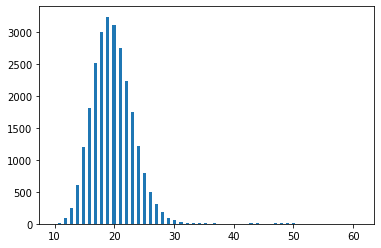

In [288]:
print(J.number_of_nodes())
print(J.number_of_edges())
x = sorted([d for n, d in J.degree()], reverse=True)

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 100, density=False)
fig.canvas.draw()
plt.show()


In [282]:
top_claims = sorted(((calc_undir_weight(J, n), n) for n in J.nodes()), reverse=True)
print(top_claims[:100])

[(314444, '37605'), (314444, '37604'), (183739, '37601'), (182951, '37600'), (105930, '46'), (69389, '44'), (54588, '11'), (54008, '12'), (49642, '45'), (43828, '48199'), (43738, '48198'), (40217, '48182'), (40217, '48181'), (30272, '253'), (29848, '632'), (26541, '2339'), (23897, '47835'), (23897, '47834'), (21955, '31605'), (21952, '31606'), (20910, '78'), (20706, '35232'), (20696, '35231'), (19959, '401'), (19956, '2431'), (17445, '629'), (15078, '48144'), (14793, '77'), (14792, '110'), (14179, '48143'), (13736, '13'), (13474, '14'), (12577, '319'), (11588, '338'), (11448, '168'), (10807, '513'), (9319, '79'), (7918, '337'), (7470, '341'), (7017, '344'), (6984, '169'), (6863, '631'), (6531, '473'), (6367, '472'), (5409, '109'), (4874, '47713'), (4873, '47868'), (4869, '34791'), (4809, '34790'), (4542, '35360'), (4539, '35359'), (4503, '48152'), (4182, '47823'), (4150, '47822'), (4135, '47820'), (4086, '47819'), (3990, '269'), (3971, '802'), (3964, '69'), (3917, '29273'), (3914, '297

In [323]:
nx.write_gml(J, "Datasets/ripple-greedy.gml")

In [157]:
target = '13140'
check_set = set(H['4'])

def verify(H, k, target):
    check_set = set(H[k])
    return target in check_set


# Hop 1
if verify(H, '4', target):
    print("Hop 1")
# Hop 2
print("Hop 2")
for k in H['4']:
    if verify(H, k, target):
        print("Target in ", k, " neighb")
    else: 


    
    
    
    

Hop 2


In [184]:
d1 = dict(nx.shortest_path_length(H, '4'))

In [177]:
nx.centrality.closenes(G, '4')

0.14982711261016385

In [ ]:
for g in G_o.nodes():
    g.add

25886
502211


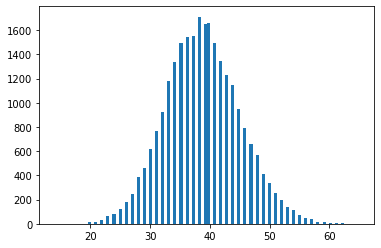

In [116]:
print(G_o.number_of_nodes())
print(G_o.number_of_edges())
x = sorted([d for n, d in G_o.degree()], reverse=True)

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 100, density=False)
fig.canvas.draw()
plt.show()

## Intersection between overlay/content

In [ ]:
x = sorted([(d,n) for n, d in G_o.degree()], reverse=True)
for d,n in x[:30]:
    dG[n]
    cont_map[n]
    
    

In [5]:
x = sorted([(d,n) for n, d in G.degree()], reverse=True)
initial_minters = [n for d,n in x[:10]]

In [52]:
val1 = sorted([(w['weight'], n) for n,w in  dict(G['3']).items()], reverse=True)
sum1 = sum((pair[0] for pair in val1))

In [35]:
[(2, '7'), (1, '4'), (1, '1528'), (1, '13140'), (1, '12844'), (1, '128')]

5

In [55]:
ind = None
cur_ind = 0
rand = randint(0, sum1 - 1)
for v in val1:
    if cur_ind + v[0] > rand:
        ind = v[1]
        break
    cur_ind += v[0]

In [ ]:
x = sorted([(d,n) for n, d in G.degree()], reverse=True)
initial_minters = [n for d,n in x[:10]]

In [319]:
peers = {k:Peer(k, list(J[k]), chain_budget=10000, peer_budget=3, wit_count=5, weight_set=dict(J[k])) for k in J.nodes()}

t = 15
tx_size = 1
frontier = []
failed_txs = 0
failed = set()

for k in initial_minters:
    peers[k].mint(10000)
    for l in range(t):
        val = peers[k].random_spend_claim(tx_size)
        if not val or type(val)==tuple:
            failed_txs+=1
            failed.add((k, val[1]))
        else:
            frontier.append(val)

for h in range(3):
    new_frontier = []
    tx_size /= (t+1)
    for k in frontier:
        for l in range(t):
            val = peers[k].random_spend_claim(tx_size)
            if not val or type(val)==tuple:
                failed_txs+=1
                failed.add((k, val[1]))
            else:
                new_frontier.append(val)
    frontier = new_frontier
print(failed_txs)    

6020


## Total complexity per Peer

### Burden for the transaction chain 

The more degree of the peer the higher the burden. 


Total transaction in the system  1078790


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


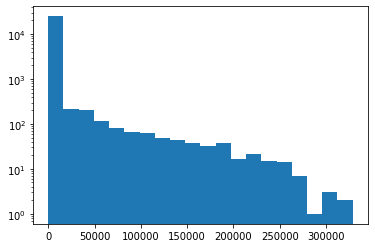

In [320]:
x = sorted([ sum(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)

print("Total transaction in the system ",sum([len(peers[n].chain) for n in G.nodes()]))

fig = plt.figure()
plt.yscale("log")
#plt.xscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total transaction in the system  93469


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


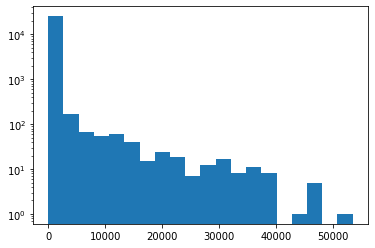

In [318]:
x = sorted([ sum(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)

print("Total transaction in the system ",sum([len(peers[n].chain) for n in G.nodes()]))

fig = plt.figure()
plt.yscale("log")
#plt.xscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total transaction in the system  389064


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


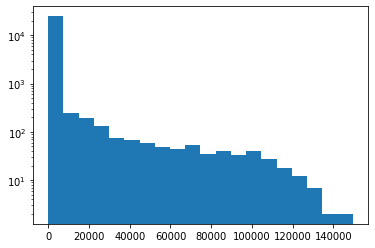

In [313]:
x = sorted([ sum(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)

print("Total transaction in the system ",sum([len(peers[n].chain) for n in G.nodes()]))

fig = plt.figure()
plt.yscale("log")
#plt.xscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total transaction in the system  185961


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


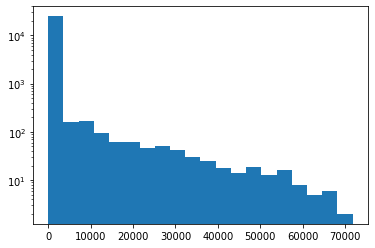

In [311]:
x = sorted([ sum(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)

print("Total transaction in the system ",sum([len(peers[n].chain) for n in G.nodes()]))

fig = plt.figure()
plt.yscale("log")
#plt.xscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total transaction in the system  221888


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


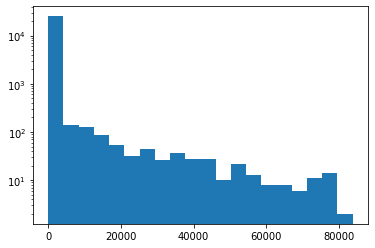

In [301]:
x = sorted([ sum(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)

print("Total transaction in the system ",sum([len(peers[n].chain) for n in G.nodes()]))

fig = plt.figure()
plt.yscale("log")
#plt.xscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total transaction in the system  222140


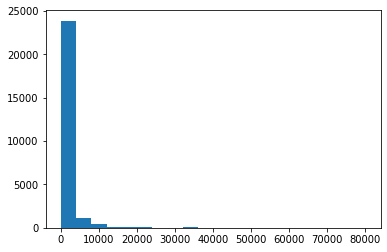

In [7]:
x = sorted([ sum(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)

print("Total transaction in the system ",sum([len(peers[n].chain) for n in G.nodes()]))

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total transaction in the system  222121


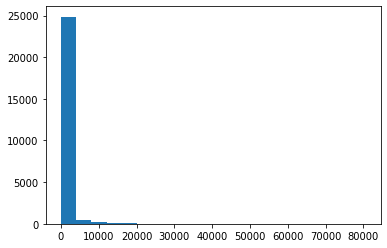

In [70]:
x = sorted([ sum(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)

print("Total transaction in the system ",sum([len(peers[n].chain) for n in G.nodes()]))

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total transaction in the system  199149


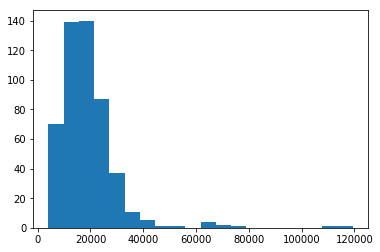

In [10]:
x = sorted([ sum(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)

print("Total transaction in the system ",sum([len(peers[n].chain) for n in G.nodes()]))

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

In [8]:
x = sorted([ (sum(peers[n].last_neigh_chain.values()), n, G.degree(n)) for n in G.nodes()], reverse=True)
print("Top by transaction burden ", *x[:20], sep="\n")
print("Lowest by transaction burden ", *x[-20:], sep="\n")

Top by transaction burden 
(22744, 83, 30)
(22565, 450, 24)
(20671, 963, 25)
(20615, 899, 24)
(20515, 408, 28)
(20309, 405, 33)
(20269, 160, 20)
(20247, 71, 18)
(20035, 591, 24)
(19979, 490, 28)
(19762, 316, 25)
(19423, 727, 21)
(19249, 864, 28)
(18887, 181, 33)
(18879, 656, 21)
(18823, 600, 33)
(18813, 682, 27)
(18722, 36, 18)
(18596, 189, 19)
(18454, 824, 36)
Lowest by transaction burden 
(5241, 35, 18)
(4955, 281, 17)
(4832, 466, 14)
(4816, 297, 21)
(4809, 851, 17)
(4796, 104, 12)
(4784, 223, 17)
(4642, 985, 17)
(4632, 637, 14)
(4247, 816, 17)
(4184, 377, 26)
(4138, 714, 16)
(4031, 445, 20)
(3879, 876, 19)
(3678, 738, 17)
(3658, 653, 17)
(3245, 378, 22)
(3228, 195, 19)
(2515, 336, 9)
(2236, 716, 14)


### Burden for the known and verified peers


The number of known/verified peers depends on two factors: 
 - The degree of the node
 - Number of mining/minting. The minter usually have less burden on the known peers


Total peers in the system  25886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


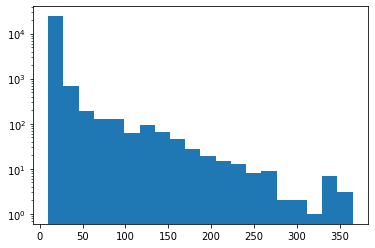

In [321]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
plt.yscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  25886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


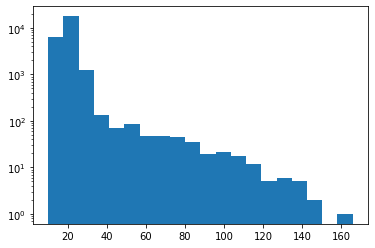

In [309]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
plt.yscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  25886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


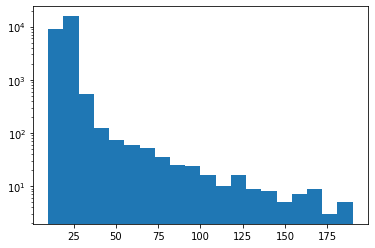

In [302]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
plt.yscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  25886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


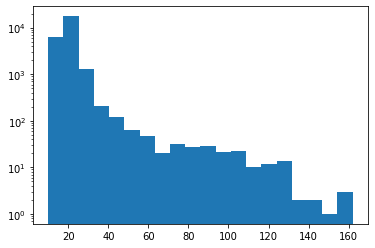

In [291]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
plt.yscale("log")
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  25886


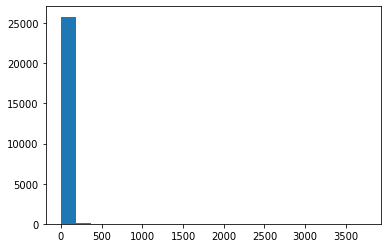

In [71]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  500


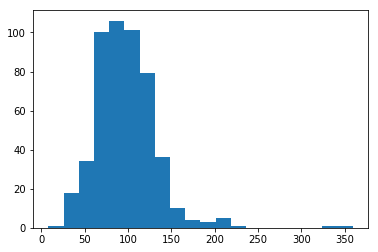

In [11]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  1000


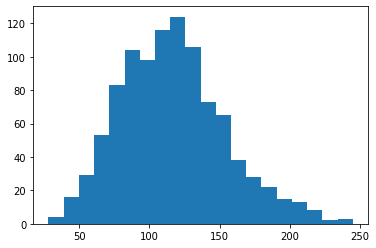

In [114]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  1000


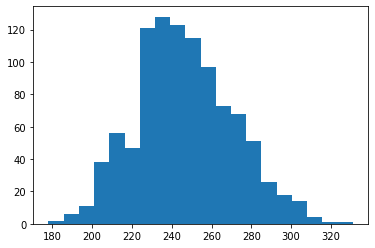

In [109]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  1000


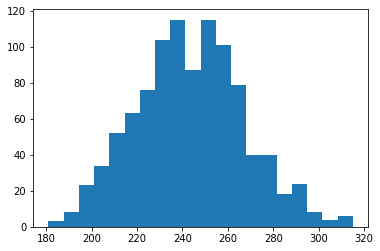

In [106]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  1000


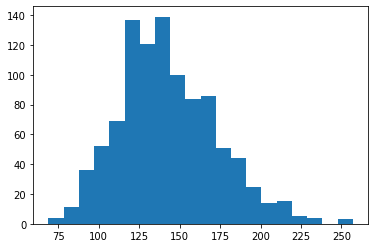

In [102]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  1000


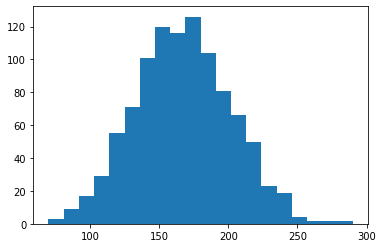

In [100]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  1000


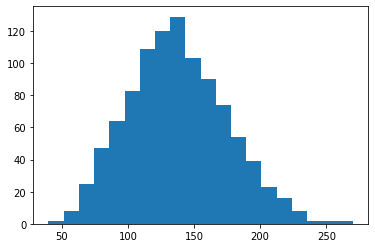

In [96]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  1000


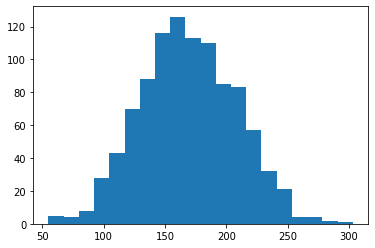

In [93]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

Total peers in the system  1000


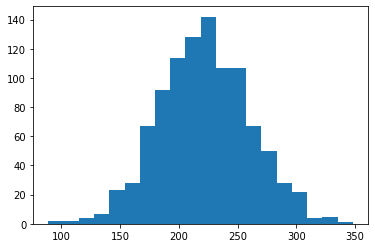

In [90]:
x = sorted([ len(peers[n].last_neigh_chain.values()) for n in G.nodes()], reverse=True)
print('Total peers in the system ', G.number_of_nodes())


fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 20, density=False)
fig.canvas.draw()
plt.show()

In [58]:
x = sorted([ (len(peers[n].last_neigh_chain.values()), n, G.degree(n)) for n in G.nodes()], reverse=True)
print("Top by known peers burden ", *x[:20], sep="\n")
print("Lowest  by known peers burden ", *x[-20:], sep="\n")

Top by known peers burden 
(913, 336, 9)
(774, 364, 10)
(599, 886, 17)
(531, 770, 14)
(489, 930, 16)
(470, 237, 17)
(463, 674, 16)
(452, 197, 15)
(450, 387, 19)
(446, 448, 15)
(433, 527, 14)
(425, 557, 17)
(409, 518, 12)
(409, 466, 14)
(393, 213, 20)
(386, 855, 16)
(365, 889, 17)
(339, 844, 13)
(328, 997, 21)
(320, 983, 19)
Lowest  by known peers burden 
(30, 868, 30)
(30, 696, 27)
(30, 540, 24)
(30, 514, 24)
(30, 275, 26)
(30, 29, 26)
(29, 792, 18)
(29, 635, 27)
(29, 575, 27)
(29, 497, 20)
(28, 874, 20)
(28, 814, 24)
(26, 869, 24)
(26, 317, 21)
(25, 710, 23)
(25, 452, 23)
(25, 61, 24)
(24, 880, 24)
(24, 647, 24)
(23, 378, 22)
